# Getting started

In [1]:
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
from pprint import pprint

import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.curation as scur
import spikeinterface.widgets as sw

from probeinterface import read_prb

In [3]:
from datetime import datetime
from dateutil import tz
from neuroconv.datainterfaces import SpikeGadgetsRecordingInterface
from neuroconv.datainterfaces import KiloSortSortingInterface

In [4]:
# Setting for parallel processing
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")
si.set_global_job_kwargs(**global_job_kwargs)

In [5]:
# set the default path
notebook_path = os.path.abspath("SpikeInterface_Tutorial_mearec.ipynb")

In [6]:
%matplotlib inline

# Tutorial 1: MEArec
### Load data

In [7]:
# MEArec dataset
# local_path = si.download_dataset(remote_path='mearec/mearec_test_10s.h5') # this line is for contributer (datalad required)
local_path = os.path.join(os.path.dirname(notebook_path), "mearec_test_10s.h5")
recording, sorting_true = se.read_mearec(local_path)
print(recording) # BaseRecording object: base recording info
print(sorting_true) # BaseSorgin object: spike sorting related info

MEArecRecordingExtractor: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                          float32 dtype - 39.06 MiB
  file_path: C:\Users\Tatsumi\Documents\GitHub\SpikeInterface\Tutorial\mearec_test_10s.h5
MEArecSortingExtractor: 10 units - 1 segments - 32.0kHz
  file_path: C:\Users\Tatsumi\Documents\GitHub\SpikeInterface\Tutorial\mearec_test_10s.h5


### Visualize the traces and the spike raster plots

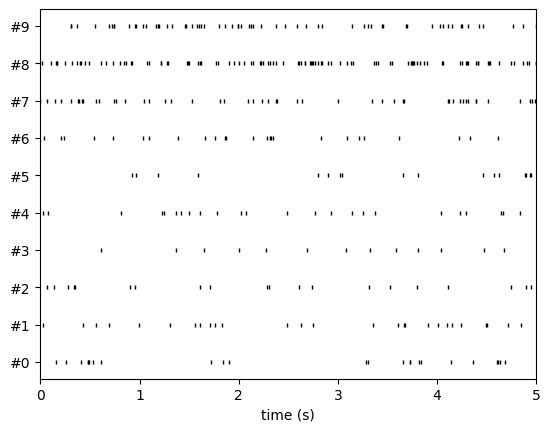

In [12]:
# w_ts = sw.plot_traces(recording, time_range=(0, 5)) # The plot_traces function does not exist anymore
w_rs = sw.plot_rasters(sorting_true, time_range=(0, 5))

### Retrieve the recording and sorting information

In [13]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)

Channel ids: ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32']
Sampling frequency: 32000.0
Number of channels: 32
Number of segments: 1


In [14]:
num_seg = recording.get_num_segments()
unit_ids = sorting_true.get_unit_ids()
spike_train = sorting_true.get_unit_spike_train(unit_id=unit_ids[0])

print('Number of segments:', num_seg)
print('Unit ids:', unit_ids)
print('Spike train of first unit:', spike_train)

Number of segments: 1
Unit ids: ['#0' '#1' '#2' '#3' '#4' '#5' '#6' '#7' '#8' '#9']
Spike train of first unit: [  5197   8413  13124  15420  15497  15668  16929  19607  55107  59060
  60958 105193 105569 117082 119243 119326 122293 122877 132413 139498
 147402 147682 148271 149857 165454 170569 174319 176237 183598 192278
 201535 217193 219715 221226 222967 223897 225338 243206 243775 248754
 253184 253308 265132 266197 266662 283149 284716 287592 304025 305286
 310438 310775 318460]


### Probe information
SpikeInterface internally uses the `ProbeInterface <https://probeinterface.readthedocs.io/en/main/>`__ to handle probeinterface.Probe and probeinterface.ProbeGroup. So any probe in the probeinterface collections can be downloaded and set to a Recording object. In this case, the MEArec dataset already handles a Probe and we don’t need to set it manually.

Probe - 32ch - 1shanks


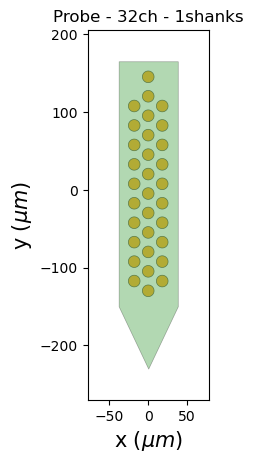

In [15]:
probe = recording.get_probe()
print(probe)

from probeinterface.plotting import plot_probe

_ = plot_probe(probe)

## Preprocessing
Using the `spikeinterface.preprocessing`, you can perform preprocessing on the recordings. Each preprocessing function also returns a `BaseRecording`, which makes it easy to build pipelines. Here, we filter the recording and apply common median reference (CMR). All these preprocessing steps are “lazy”. The computation is done on demand when we call `recording.get_traces(...)` or when we save the object to disk.

In [18]:
recording_cmr = recording
recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=6000) # bandpass filter from the core module
print(recording_f)
recording_cmr = spre.common_reference(recording_f, reference='global',operator='median') # CMR from the core module
print(recording_cmr)

# this computes and saves the recording after applying the preprocessing chain
recording_preprocessed = recording_cmr.save(format='binary')
print(recording_preprocessed)

BandpassFilterRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                         float32 dtype - 39.06 MiB
CommonReferenceRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                          float32 dtype - 39.06 MiB
Use cache_folder=C:\Users\Tatsumi\AppData\Local\Temp\spikeinterface_cache\tmpx_b3r_jj\2H98Q43E
write_binary_recording with n_jobs = 4 and chunk_size = 32000


write_binary_recording:   0%|          | 0/10 [00:00<?, ?it/s]

BinaryFolderRecording: 32 channels - 32.0kHz - 1 segments - 320,000 samples - 10.00s 
                       float32 dtype - 39.06 MiB


## Spikesorting

In [20]:
# Print available and installed spike sorters
print('Available sorters', ss.available_sorters())
print('Installed sorters', ss.installed_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'mountainsort5', 'pykilosort', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['spykingcircus2', 'tridesclous', 'tridesclous2']


In [22]:
# See default parameters of sorters
print("Tridesclous params:")
pprint(ss.get_default_sorter_params('tridesclous'))
print("SpykingCircus2 params:")
pprint(ss.get_default_sorter_params('spykingcircus2'))

Tridesclous params:
{'chunk_duration': '1s',
 'common_ref_removal': False,
 'detect_sign': -1,
 'detect_threshold': 5,
 'freq_max': 5000.0,
 'freq_min': 400.0,
 'n_jobs': 8,
 'nested_params': None,
 'progress_bar': True}
SpykingCircus2 params:
{'apply_preprocessing': True,
 'clustering': {},
 'detection': {'detect_threshold': 5, 'peak_sign': 'neg'},
 'filtering': {'dtype': 'float32'},
 'general': {'local_radius_um': 100, 'ms_after': 2, 'ms_before': 2},
 'job_kwargs': {},
 'localization': {},
 'matching': {},
 'registration': {},
 'selection': {'min_n_peaks': 20000, 'n_peaks_per_channel': 5000},
 'shared_memory': False,
 'waveforms': {'max_spikes_per_unit': 200, 'overwrite': True}}


In [23]:
# Run Tridesclous and change detect_threshold
sorting_TDC = ss.run_sorter(sorter_name="tridesclous", recording=recording_preprocessed, detect_threshold=4)
print(sorting_TDC)

TridesclousSortingExtractor: 10 units - 1 segments - 32.0kHz


In [24]:
# Alternative way to specify parameters as a full dictionary
other_params = ss.get_default_sorter_params('tridesclous')
other_params['detect_threshold'] = 6

# parameters set by params dictionary
sorting_TDC_2 = ss.run_sorter(sorter_name="tridesclous", recording=recording_preprocessed,
                              output_folder="tdc_output2", **other_params)
print(sorting_TDC_2)

TridesclousSortingExtractor: 9 units - 1 segments - 32.0kHz


In [25]:
# Run SpikingCircus2
sorting_SC2 = ss.run_sorter(sorter_name="spykingcircus2", recording=recording_preprocessed)
print(sorting_SC2)

NpzFolderSorting: 10 units - 1 segments - 32.0kHz


In [26]:
# See the BaseSorting objects resulted from spike sorting
print('Units found by tridesclous:', sorting_TDC.get_unit_ids())
print('Units found by spyking-circus2:', sorting_SC2.get_unit_ids())

Units found by tridesclous: [0 1 2 3 4 5 6 7 8 9]
Units found by spyking-circus2: [0 1 2 3 4 5 6 7 8 9]


In [28]:
# Run kilosort using Docker
sorting_KS2 = ss.run_sorter(sorter_name="kilosort2", recording=recording_preprocessed,
                            docker_image=True, verbose=True)
print(sorting_KS2)

AssertionError: The container requires a NVIDIA GPU capability, but it is not available

## Postprocessing
SpikeInterface provides a efficient way to extract waveforms from paired recording/sorting objects. The `extract_waveforms` function samples some spikes (by default `max_spikes_per_unit=500`) for each unit, extracts, their waveforms, and stores them to disk. These waveforms are helpful to compute the average waveform, or “template”, for each unit and then to compute, for example, quality metrics.

In [45]:
we_TDC = si.extract_waveforms(recording_preprocessed, sorting_TDC, 'waveforms_folder', overwrite=True)
print(we_TDC)

unit_id0 = sorting_TDC.unit_ids[0]
waveforms = we_TDC.get_waveforms(unit_id0)
print(waveforms.shape)

template = we_TDC.get_template(unit_id0)
print(template.shape)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'waveforms_folder\\waveforms\\waveforms_0.npy'

`we_TDC` is a have the `WaveformExtractor` object we can post-process, validate, and curate the results. With the `spikeinterface.postprocessing` submodule, one can, for example, compute spike amplitudes, PCA projections, unit locations, and more.

In [46]:
# Compute some postprocessing information
amplitudes = spost.compute_spike_amplitudes(we_TDC)
unit_locations = spost.compute_unit_locations(we_TDC)
spike_locations = spost.compute_spike_locations(we_TDC)
correlograms, bins = spost.compute_correlograms(we_TDC)
similarity = spost.compute_template_similarity(we_TDC)

extract amplitudes:   0%|          | 0/10 [00:00<?, ?it/s]

localize peaks using center_of_mass:   0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
# All of this postprocessing functions are saved in the waveforms folder as extensions
print(we_TDC.get_available_extension_names())

['similarity', 'spike_amplitudes', 'correlograms', 'spike_locations', 'unit_locations', 'quality_metrics']


In [33]:
#  waveform extractors (and all extensions) can be reloaded at later times
we_loaded = si.load_waveforms('waveforms_folder')
print(we_loaded.get_available_extension_names())

['similarity', 'spike_amplitudes', 'correlograms', 'spike_locations', 'unit_locations']


### Quality metrics
Once we have computed all these postprocessing information, we can compute quality metrics (different quality metrics require different extensions - e.g., drift metrics require `spike_locations`):

In [41]:
# One-time initialization of Kachery-cloud (alternate method)
import kachery_cloud as kcl
kcl.init()


https://kachery-gateway.figurl.org/registerClient/c6ae8fa29973e01fbd3c33b1c743b1b19ca1603087bf383995d6f4c71d36b665?signature=39889427e92020fd97f277f14de0783b714aa522aff22d68aaacbb5c5ed499768cbf600b5f15706f876737e5b595485e0c7bd6a062f59c46d5cfc8376dec5b08&zone=default&label=DESKTOP-TJEKJ14

Click the above link to register this kachery cloud client. After pressing the "REGISTER CLIENT" button on the website, press [Enter] in this terminal to continue.



Checking...
Client initialized successfully.
Client ID: c6ae8fa29973e01fbd3c33b1c743b1b19ca1603087bf383995d6f4c71d36b665
Label: DESKTOP-TJEKJ14
Owner: ttmysd70c6f5

* Kachery-cloud is intended for collaborative sharing of data for scientific research. It should not be used for other purposes.


In [36]:
qm_params = sqm.get_default_qm_params()
pprint(qm_params)

{'amplitude_cutoff': {'amplitudes_bins_min_ratio': 5,
                      'histogram_smoothing_value': 3,
                      'num_histogram_bins': 100,
                      'peak_sign': 'neg'},
 'amplitude_median': {'peak_sign': 'neg'},
 'drift': {'direction': 'y',
           'interval_s': 60,
           'min_num_bins': 2,
           'min_spikes_per_interval': 100},
 'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0},
 'nearest_neighbor': {'max_spikes': 10000, 'n_neighbors': 5},
 'nn_isolation': {'max_spikes': 10000,
                  'min_fr': 0.0,
                  'min_spikes': 10,
                  'n_components': 10,
                  'n_neighbors': 4,
                  'peak_sign': 'neg',
                  'radius_um': 100},
 'nn_noise_overlap': {'max_spikes': 10000,
                      'min_fr': 0.0,
                      'min_spikes': 10,
                      'n_components': 10,
                      'n_neighbors': 4,
                      'peak_sign': 'neg',


In [37]:
# Modify some parameters for short recordings
qm_params["presence_ratio"]["bin_duration_s"] = 1
qm_params["amplitude_cutoff"]["num_histogram_bins"] = 5
qm_params["drift"]["interval_s"] = 2
qm_params["drift"]["min_spikes_per_interval"] = 2

In [51]:
# Export quality metrics
qm = sqm.compute_quality_metrics(we_TDC, qm_params=qm_params)
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,drift_ptp,drift_std,drift_mad
0,30.0,3.0,0.9,27.321539,0.0,0.0,0.0,0.0,NaN,0.200717,307.199036,1.052532,0.424653,0.421992
1,51.0,5.1,1.0,24.203907,0.0,0.0,0.0,0.0,NaN,0.500000,274.444977,0.995004,0.344932,0.261774
2,53.0,5.3,0.9,24.146858,0.0,0.0,0.0,0.0,NaN,0.500000,270.204590,1.355411,0.541736,0.567367
3,50.0,5.0,1.0,26.732096,0.0,0.0,0.0,0.0,NaN,0.500000,312.545715,0.421523,0.146277,0.112580
4,36.0,3.6,1.0,9.582793,0.0,0.0,0.0,0.0,NaN,0.207231,107.953278,1.941205,0.688280,0.556732
5,42.0,4.2,1.0,13.225080,0.0,0.0,0.0,0.0,NaN,0.204838,151.833191,0.927884,0.314812,0.186148
6,48.0,4.8,1.0,8.272636,0.0,0.0,0.0,0.0,NaN,0.500000,91.358444,2.084521,0.753820,0.385204
7,193.0,19.3,1.0,8.786592,0.0,0.0,0.0,0.0,0.155,0.500000,103.491577,1.191062,0.452649,0.485258
8,129.0,12.9,1.0,11.034074,0.0,0.0,0.0,0.0,0.310,0.500000,128.252319,1.116480,0.440774,0.477920
9,110.0,11.0,1.0,8.323404,0.0,0.0,0.0,0.0,0.270,0.203415,98.207291,1.395852,0.561095,0.632810


We can export a sorting summary and quality metrics plot using the `sortingview` backend. This will generate shareble links for web-based visualization.

In [53]:
w1 = sw.plot_quality_metrics(we_TDC, display=False, backend="sortingview")

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://1cb88def93b5c1dbe08bc13cfab1edc6b42a12ce&label=SpikeInterface%20-%20Quality%20Metrics


In [48]:
w2 = sw.plot_sorting_summary(we_TDC, display=False, curation=True, backend="sortingview")

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://8c774fe642562d24351aa7b984c7d32339c37e3e&label=SpikeInterface%20-%20Sorting%20Summary


The sorting summary plot can also be used for manual labeling and curation. In the example above, we manually merged two units (0, 4) and added accept labels (2, 6, 7). After applying our curation, we can click on the “Save as snapshot (sha://)” and copy the URI:

In [56]:
uri = "sha1://68cb54a9aaed2303fb82dedbc302c853e818f1b6"

sorting_curated_sv = scur.apply_sortingview_curation(sorting_TDC, uri_or_json=uri)
print(sorting_curated_sv)
print(sorting_curated_sv.get_property("accept"))

MergeUnitsSorting: 9 units - 1 segments - 32.0kHz
[False  True False False  True  True False False False]


In [57]:
# Alternatively, I can export the data locally to Phy
sexp.export_to_phy(we_TDC, 'phy_folder_for_TDC', verbose=True)

write_binary_recording:   0%|          | 0/10 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/10 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/10 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/10 [00:00<?, ?it/s]

Run:
phy template-gui  C:\Users\Tatsumi\Documents\GitHub\SpikeInterface\Tutorial\phy_folder_for_TDC\params.py


In [58]:
# Load the data from Phy
sorting_curated_phy = se.read_phy('phy_folder_for_TDC', exclude_cluster_groups=["noise"])

Quality metrics can be also used to automatically curate the spike sorting output. For example, you can select sorted units with a SNR above a certain threshold:

In [59]:
keep_mask = (qm['snr'] > 10) & (qm['isi_violations_ratio'] < 0.01)
print("Mask:", keep_mask.values)

sorting_curated_auto = sorting_TDC.select_units(sorting_TDC.unit_ids[keep_mask])
print(sorting_curated_auto)

Mask: [ True  True  True  True False  True False False  True False]
UnitsSelectionSorting: 6 units - 1 segments - 32.0kHz


### Comparing spike sorting outputs
compare the spike sorting results with the ground-truth sorting `sorting_true`
compare the output of two (Tridesclous and SpykingCircus 


compare the output of multiple sorters (Tridesclous, SpykingCircus2, Kiloso
rt2)

In [61]:
comp_gt = sc.compare_sorter_to_ground_truth(gt_sorting=sorting_true, tested_sorting=sorting_TDC)
comp_pair = sc.compare_two_sorters(sorting1=sorting_TDC, sorting2=sorting_SC2)
# comp_multi = sc.compare_multiple_sorters(sorting_list=[sorting_TDC, sorting_SC2, sorting_KS2],
                                         # name_list=['tdc', 'sc2', 'ks2'])

            accuracy    recall precision false_discovery_rate miss_rate
gt_unit_id                                                             
#0               1.0       1.0       1.0                  0.0       0.0
#1               1.0       1.0       1.0                  0.0       0.0
#2          0.976744  0.976744       1.0                  0.0  0.023256
#3               1.0       1.0       1.0                  0.0       0.0
#4               1.0       1.0       1.0                  0.0       0.0
#5          0.972973  0.972973       1.0                  0.0  0.027027
#6               1.0       1.0       1.0                  0.0       0.0
#7          0.990991  0.990991       1.0                  0.0  0.009009
#8          0.989744  0.989744       1.0                  0.0  0.010256
#9               1.0       1.0       1.0                  0.0       0.0


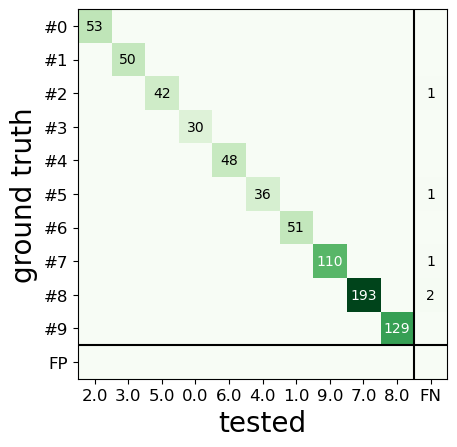

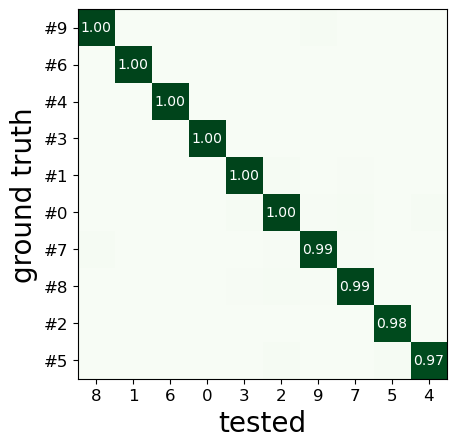

In [62]:
print(comp_gt.get_performance())
w_conf = sw.plot_confusion_matrix(comp_gt)
w_agr = sw.plot_agreement_matrix(comp_gt)

In [64]:
# Match units between sorters
comp_pair.hungarian_match_12
# comp_pair.hungarian_match_21 # reverse

0    0.0
1    6.0
2    2.0
3    7.0
4    5.0
5    8.0
6    1.0
7    4.0
8    3.0
9    9.0
dtype: float64

In [65]:
# When comparing multiple sorters
sorting_agreement = comp_multi.get_agreement_sorting(minimum_agreement_count=2)

print('Units in agreement between TDC, SC2, and KS2:', sorting_agreement.get_unit_ids())

w_multi = sw.plot_multicomp_agreement(comp_multi)
w_multi = sw.plot_multicomp_agreement_by_sorter(comp_multi)

NameError: name 'comp_multi' is not defined

# Tutorial 2: Spikegadgets non-NP dataset

## Preprocessing

In [4]:
# Load a Spikegadgets .rec file
local_path = os.path.join(os.path.dirname(notebook_path), "spikegadgets_tutorial.rec")
recording = se.read_spikegadgets(local_path,stream_name='trodes')
print(recording) # BaseRecording object: base recording info
# print(sorting_true) # BaseSorgin object: spike sorting related info

SpikeGadgetsRecordingExtractor: 512 channels - 30.0kHz - 1 segments - 8,000 samples 
                                0.27s (266.67 ms) - int16 dtype - 7.81 MiB
  file_path: C:\Users\Tatsumi\Documents\GitHub\SpikeInterface\Tutorial\spikegadgets_tutorial.rec


In [5]:
# BaseRecording information
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_seg = recording.get_num_segments()

print('Channel ids:', channel_ids)
print('Sampling frequency:', fs)
print('Number of channels:', num_chan)
print('Number of segments:', num_seg)

Channel ids: ['56' '58' '60' '62' '48' '50' '52' '54' '40' '42' '44' '46' '32' '34'
 '36' '38' '88' '90' '92' '94' '80' '82' '84' '86' '72' '74' '76' '78'
 '68' '66' '64' '70' '65' '67' '69' '71' '73' '75' '77' '79' '81' '83'
 '85' '87' '95' '91' '93' '89' '97' '99' '101' '103' '105' '107' '109'
 '111' '113' '115' '117' '119' '123' '125' '127' '121' '120' '122' '124'
 '126' '112' '114' '116' '118' '104' '106' '108' '110' '96' '98' '100'
 '102' '24' '26' '28' '30' '22' '18' '20' '16' '8' '10' '12' '14' '0' '2'
 '4' '6' '9' '11' '13' '15' '17' '19' '21' '23' '1' '3' '5' '7' '25' '27'
 '29' '31' '33' '35' '37' '39' '41' '43' '45' '47' '49' '51' '53' '55'
 '57' '59' '61' '63' '157' '153' '156' '149' '137' '141' '144' '152' '191'
 '187' '183' '179' '174' '170' '166' '162' '136' '145' '148' '140' '160'
 '133' '128' '132' '190' '186' '182' '178' '175' '171' '167' '163' '155'
 '151' '147' '142' '138' '134' '130' '139' '188' '185' '181' '177' '172'
 '168' '164' '159' '143' '135' '129' '131' '15

### Common median reference

In [6]:
recording_cmr = recording
recording_f = spre.bandpass_filter(recording, freq_min=300, freq_max=6000) # bandpass filter from the core module
print(recording_f)
recording_cmr = spre.common_reference(recording_f, reference='global',operator='median') # CMR from the core module
print(recording_cmr)

# this computes and saves the recording after applying the preprocessing chain
recording_preprocessed = recording_cmr.save(format='binary')
print(recording_preprocessed)

BandpassFilterRecording: 512 channels - 30.0kHz - 1 segments - 8,000 samples - 0.27s (266.67 ms) 
                         int16 dtype - 7.81 MiB
CommonReferenceRecording: 512 channels - 30.0kHz - 1 segments - 8,000 samples - 0.27s (266.67 ms) 
                          int16 dtype - 7.81 MiB
Use cache_folder=C:\Users\Tatsumi\AppData\Local\Temp\spikeinterface_cache\tmp5c54sjsh\COMAS3C6
write_binary_recording with n_jobs = 4 and chunk_size = 30000


write_binary_recording:   0%|          | 0/1 [00:00<?, ?it/s]

BinaryFolderRecording: 512 channels - 30.0kHz - 1 segments - 8,000 samples - 0.27s (266.67 ms) 
                       int16 dtype - 7.81 MiB


### Handling probes
In order to handle probe information, SpikeInterface relies on the probeinterface package. Either a Probe or a ProbeGroup object can be attached to a recording and it loads probe information (particularly channel locations and sometimes groups). ProbeInterface also has a library of available probes, so that you can download and attach an existing probe to a recording with a few lines of code. When a probe is attached to a recording, the `location` property is automatically set. In addition, the `contact_vector` property will carry detailed information of the probe design.

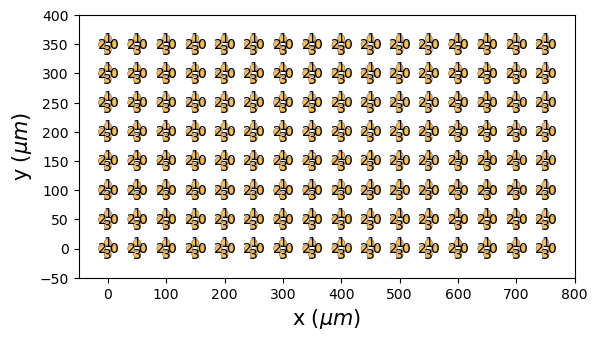

In [7]:
# Handling probe information
# Generate 16*8 = 128 tetrodes
import numpy as np
import matplotlib.pyplot as plt

from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import generate_tetrode

probegroup = ProbeGroup()
for i in range(16):
    for j in range(8):
        tetrode = generate_tetrode()
        tetrode.move([i * 50, j * 50])
        probegroup.add_probe(tetrode)
probegroup.set_global_device_channel_indices(np.arange(512))

df = probegroup.to_dataframe()
df

plot_probe_group(probegroup, with_channel_index=True, same_axes=True)

In [8]:
# set probegroup to the recording
recording_128_tetrodes = recording_preprocessed.set_probegroup(probegroup,group_mode='by_probe')
# get group
print(recording_128_tetrodes.get_channel_groups())

[  0   0   0   0   1   1   1   1   2   2   2   2   3   3   3   3   4   4
   4   4   5   5   5   5   6   6   6   6   7   7   7   7   8   8   8   8
   9   9   9   9  10  10  10  10  11  11  11  11  12  12  12  12  13  13
  13  13  14  14  14  14  15  15  15  15  16  16  16  16  17  17  17  17
  18  18  18  18  19  19  19  19  20  20  20  20  21  21  21  21  22  22
  22  22  23  23  23  23  24  24  24  24  25  25  25  25  26  26  26  26
  27  27  27  27  28  28  28  28  29  29  29  29  30  30  30  30  31  31
  31  31  32  32  32  32  33  33  33  33  34  34  34  34  35  35  35  35
  36  36  36  36  37  37  37  37  38  38  38  38  39  39  39  39  40  40
  40  40  41  41  41  41  42  42  42  42  43  43  43  43  44  44  44  44
  45  45  45  45  46  46  46  46  47  47  47  47  48  48  48  48  49  49
  49  49  50  50  50  50  51  51  51  51  52  52  52  52  53  53  53  53
  54  54  54  54  55  55  55  55  56  56  56  56  57  57  57  57  58  58
  58  58  59  59  59  59  60  60  60  60  61  61  6

### Spike sorting by group
For tetrodes, spike sorting should be processed using a specific grouping. Alternatively, for long silicon probes, such as Neuropixels, one could think of spike sorting different areas separately, for example using a different sorter for the hippocampus, the thalamus, or the cerebellum.

A `BaseRecording` object has the ability to split itself into a dictionary of sub-recordings given a certain property (see `split_by()`). So it is easy to loop over this dictionary and sequentially run spike sorting on these sub-recordings. SpikeInterface also provides a high-level function to automate the process of splitting the recording and then aggregating the results with the run_sorter_by_property() function.

In [9]:
# Available spike sorters
print('Available sorters', ss.available_sorters())
print('Installed sorters', ss.installed_sorters())

Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'klusta', 'mountainsort4', 'mountainsort5', 'pykilosort', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['spykingcircus2', 'tridesclous', 'tridesclous2']


In [11]:
pprint(ss.get_default_sorter_params('kilosort3'))

{'AUCsplit': 0.8,
 'NT': None,
 'car': True,
 'chunk_duration': '1s',
 'delete_recording_dat': False,
 'delete_tmp_files': True,
 'detect_threshold': 6,
 'do_correction': True,
 'freq_min': 300,
 'keep_good_only': False,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nPCs': 3,
 'n_jobs': 8,
 'nblocks': 5,
 'nfilt_factor': 4,
 'ntbuff': 64,
 'preclust_threshold': 8,
 'progress_bar': True,
 'projection_threshold': [9, 9],
 'save_rez_to_mat': False,
 'scaleproc': None,
 'sig': 20,
 'sigmaMask': 30,
 'skip_kilosort_preprocessing': False,
 'wave_length': 61}


In [16]:
ss.Kilosort3Sorter.set_kilosort3_path(kilosort3_path='C:\\Users\\Tatsumi\\Documents\\GitHub\\Kilosort')

Setting KILOSORT3_PATH environment variable for subprocess calls to: C:\Users\Tatsumi\Documents\GitHub\Kilosort


In [20]:
# Manual splitting
# Split into a dict
recording_split = recording_128_tetrodes.split_by(property='group', outputs='dict')

# loop over recording and run a sorter
# here the result is a dict of a sorting object
sortings = {}
for group, sub_recording in recording_split.items():
    sorting = ss.run_sorter('kilosort3', sub_recording, output_folder=f"folder_KS2_group{group}")
    sortings[group] = sorting

SpikeSortingError: Spike sorting error trace:
Traceback (most recent call last):
  File "C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\sorters\basesorter.py", line 234, in run_from_folder
    SorterClass._run_from_folder(sorter_output_folder, sorter_params, verbose)
  File "C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\sorters\external\kilosortbase.py", line 215, in _run_from_folder
    raise Exception(f"{cls.sorter_name} returned a non-zero exit code")
Exception: kilosort3 returned a non-zero exit code

Spike sorting failed. You can inspect the runtime trace in C:\Users\Tatsumi\Documents\GitHub\SpikeInterface\Tutorial\folder_KS2_group0/spikeinterface_log.json.

# Tutorial 3: Spikegadgets Neuropixels

## Load probe information

### Extract channel map from raw file

In [17]:
import sys, os
from pathlib import Path

# current_dir = os.path.join(Path().resolve())
# sys.path.append(str(current_dir) + '/module1.py')
# sys.path.append('C:/Users/Tatsumi/Documents/GitHub/YartsevLab/Neuropixels_analysis/python/extract_chanmap_Trodes_rec.py')
from extract_chanmap_Trodes_rec import get_probegroup_np

Probe configuration:
      x     y  probe   id  hwChan
0    -8  2080      0  200     125
1    24  2080      0  199     124
2   -24  2060      0  198      89
3     8  2060      0  197      88
4    -8  2040      0  196      53
..   ..   ...    ...  ...     ...
395   8   140      1    5      90
396  -8   120      1    4      55
397  24   120      1    3      54
398 -24   100      1    2      19
399   8   100      1    1      18

[400 rows x 5 columns]


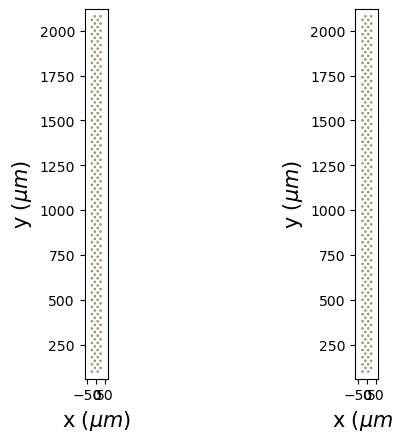

Probe file is written atC:\Users\Tatsumi\Documents\Data\KQTY_NP\32623\20230907_161730.rec\20230907_161730.prb


In [18]:
local_path = 'C:\\Users\\Tatsumi\\Documents\\Data\\KQTY_NP\\32623\\20230907_161730.rec\\20230907_161730_merged_split_1min.rec'
get_probegroup_np(local_path)

### Read probe from prb file

In [7]:
# Load probe
probe_path = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32623/20230907_161730.rec/20230907_161730.prb'
probegroup = read_prb(probe_path)

probe0 = probegroup.probes[0]
probe1 = probegroup.probes[1]

### Generate sample shift

In [26]:
total_channels = 960
num_channels_per_adc = 12
num_cycles = 13 # AP
# num_cycles = 12 # LFP
adc_indices = np.floor(np.arange(total_channels) / (num_channels_per_adc * 2)) * 2 + np.mod(np.arange(total_channels), 2)

sample_shifts = np.zeros_like(adc_indices)
for a in adc_indices:
    sample_shifts[adc_indices == a] = np.arange(num_channels_per_adc) / num_cycles

In [27]:
num_chan = probe0.get_contact_count()
inter_sample_shift = np.zeros(num_chan)

chans = probe0.device_channel_indices
for i in range(len(chans)):
    inter_sample_shift[i] = sample_shifts[chans[i]]

inter_sample_shift

array([0.23076923, 0.23076923, 0.15384615, 0.15384615, 0.07692308,
       0.07692308, 0.        , 0.        , 0.84615385, 0.84615385,
       0.76923077, 0.76923077, 0.69230769, 0.69230769, 0.61538462,
       0.61538462, 0.53846154, 0.53846154, 0.46153846, 0.46153846,
       0.38461538, 0.38461538, 0.30769231, 0.30769231, 0.23076923,
       0.23076923, 0.15384615, 0.15384615, 0.07692308, 0.07692308,
       0.        , 0.        , 0.84615385, 0.84615385, 0.76923077,
       0.76923077, 0.69230769, 0.69230769, 0.61538462, 0.61538462,
       0.53846154, 0.53846154, 0.46153846, 0.46153846, 0.38461538,
       0.38461538, 0.30769231, 0.30769231, 0.23076923, 0.23076923,
       0.15384615, 0.15384615, 0.07692308, 0.07692308, 0.        ,
       0.        , 0.84615385, 0.84615385, 0.76923077, 0.76923077,
       0.69230769, 0.69230769, 0.61538462, 0.61538462, 0.53846154,
       0.53846154, 0.46153846, 0.46153846, 0.38461538, 0.38461538,
       0.30769231, 0.30769231, 0.23076923, 0.23076923, 0.15384

## Load binary data

### Spike band
instead of loading binary file concatenated for spikeband.dat file, load kilosort.dat file. The spikeband .dat is processed when it is exported by Trodes.

In [28]:
binary_path = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32623/20230907_161730.rec/20230907_161730_merged_split1.kilosort/20230907_161730_merged_split1.probe1.dat'
sampling_frequency = 30000
dtype = 'int16'
num_channels = 200
gain_to_uV = 50
offset_to_uV = 0

rec_ap = si.read_binary(binary_path,sampling_frequency=sampling_frequency,dtype=dtype,num_channels=num_channels,gain_to_uV=gain_to_uV,offset_to_uV=offset_to_uV)
rec_ap.set_property('inter_sample_shift',inter_sample_shift)
print(rec_ap)

BinaryRecordingExtractor: 200 channels - 30.0kHz - 1 segments - 1,800,007 samples 
                          60.00s (1.00 minutes) - int16 dtype - 686.65 MiB
  file_paths: ['C:\\Users\\Tatsumi\\Documents\\Data\\KQTY_NP\\32623\\20230907_161730.rec\\20230907_161730_merged_split1.kilosort\\20230907_161730_merged_split1.probe1.dat']


In [29]:
rec_ap.get_traces()

array([[  0,   0,   0, ...,  64,  64,   0],
       [ 64, -64,  64, ..., 128,  64, 128],
       [128,   0,   0, ...,  64, 128, -64],
       ...,
       [  0,   0,  64, ...,   0, 192, -64],
       [128,   0,  64, ...,   0, 128,  64],
       [  0, -64, 128, ...,  64,  64,   0]], dtype=int16)

### Set probe

In [30]:
rec_ap.set_probe(probe0, in_place=True)
rec_ap.get_probe()

Probe - 200ch - 1shanks

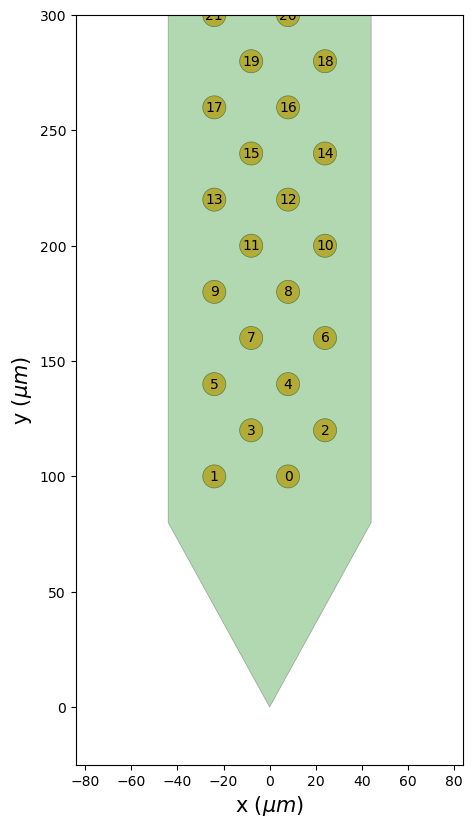

In [31]:
fig, ax = plt.subplots(figsize=(5, 10))
sw.plot_probe_map(rec_ap, ax=ax, with_channel_ids=True)
ax.set_ylim(-25, 300)
plt.show()

### LFP band

In [143]:
binary_path = 'C:/Users/Tatsumi/Documents/Data/KQTY_NP/32623/20230907_161730.rec/20230907_161730_merged_split1.binary/20230907_161730_merged_split1.LFP_probe1.dat'
sampling_frequency = 1500
dtype = 'int16'
num_channels = 200

recording = si.read_binary(binary_path,sampling_frequency=sampling_frequency,dtype=dtype,num_channels=num_channels)
print(recording)

## Preprocess the data

### Spikeband

In [32]:
rec1 = spre.highpass_filter(rec_ap, freq_min=300.)
bad_channel_ids, channel_labels = spre.detect_bad_channels(rec1)
# rec2 = rec1.remove_channels(bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)
rec2 = rec1

rec3 = spre.phase_shift(rec2)
rec4 = spre.common_reference(rec3, operator="median", reference="global")
rec_processed = rec4
rec_processed

bad_channel_ids [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


C:\Users\Tatsumi\AppData\Local\anaconda3\envs\si_env\lib\site-packages\spikeinterface\preprocessing\detect_bad_channels.py:215: UserWarning: Over 1/3 of channels are detected as bad. In the precense of a highnumber of dead / noisy channels, bad channel detection may fail (erroneously label good channels as dead).
  warnings.warn(


CommonReferenceRecording: 200 channels - 30.0kHz - 1 segments - 1,800,007 samples 
                          60.00s (1.00 minutes) - int16 dtype - 686.65 MiB

### LFP band

In [ ]:
rec1 = si.highpass_filter(recording, freq_min=400.)
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)
rec2 = rec1.remove_channels(bad_channel_ids)
print('bad_channel_ids', bad_channel_ids)

rec3 = si.phase_shift(rec2)
rec4 = si.common_reference(rec3, operator="median", reference="global")
rec = rec4
rec

## Visualization

In [38]:
%matplotlib widget
sw.plot_traces({'filter':rec1, 'cmr': rec4}, backend='ipywidgets')

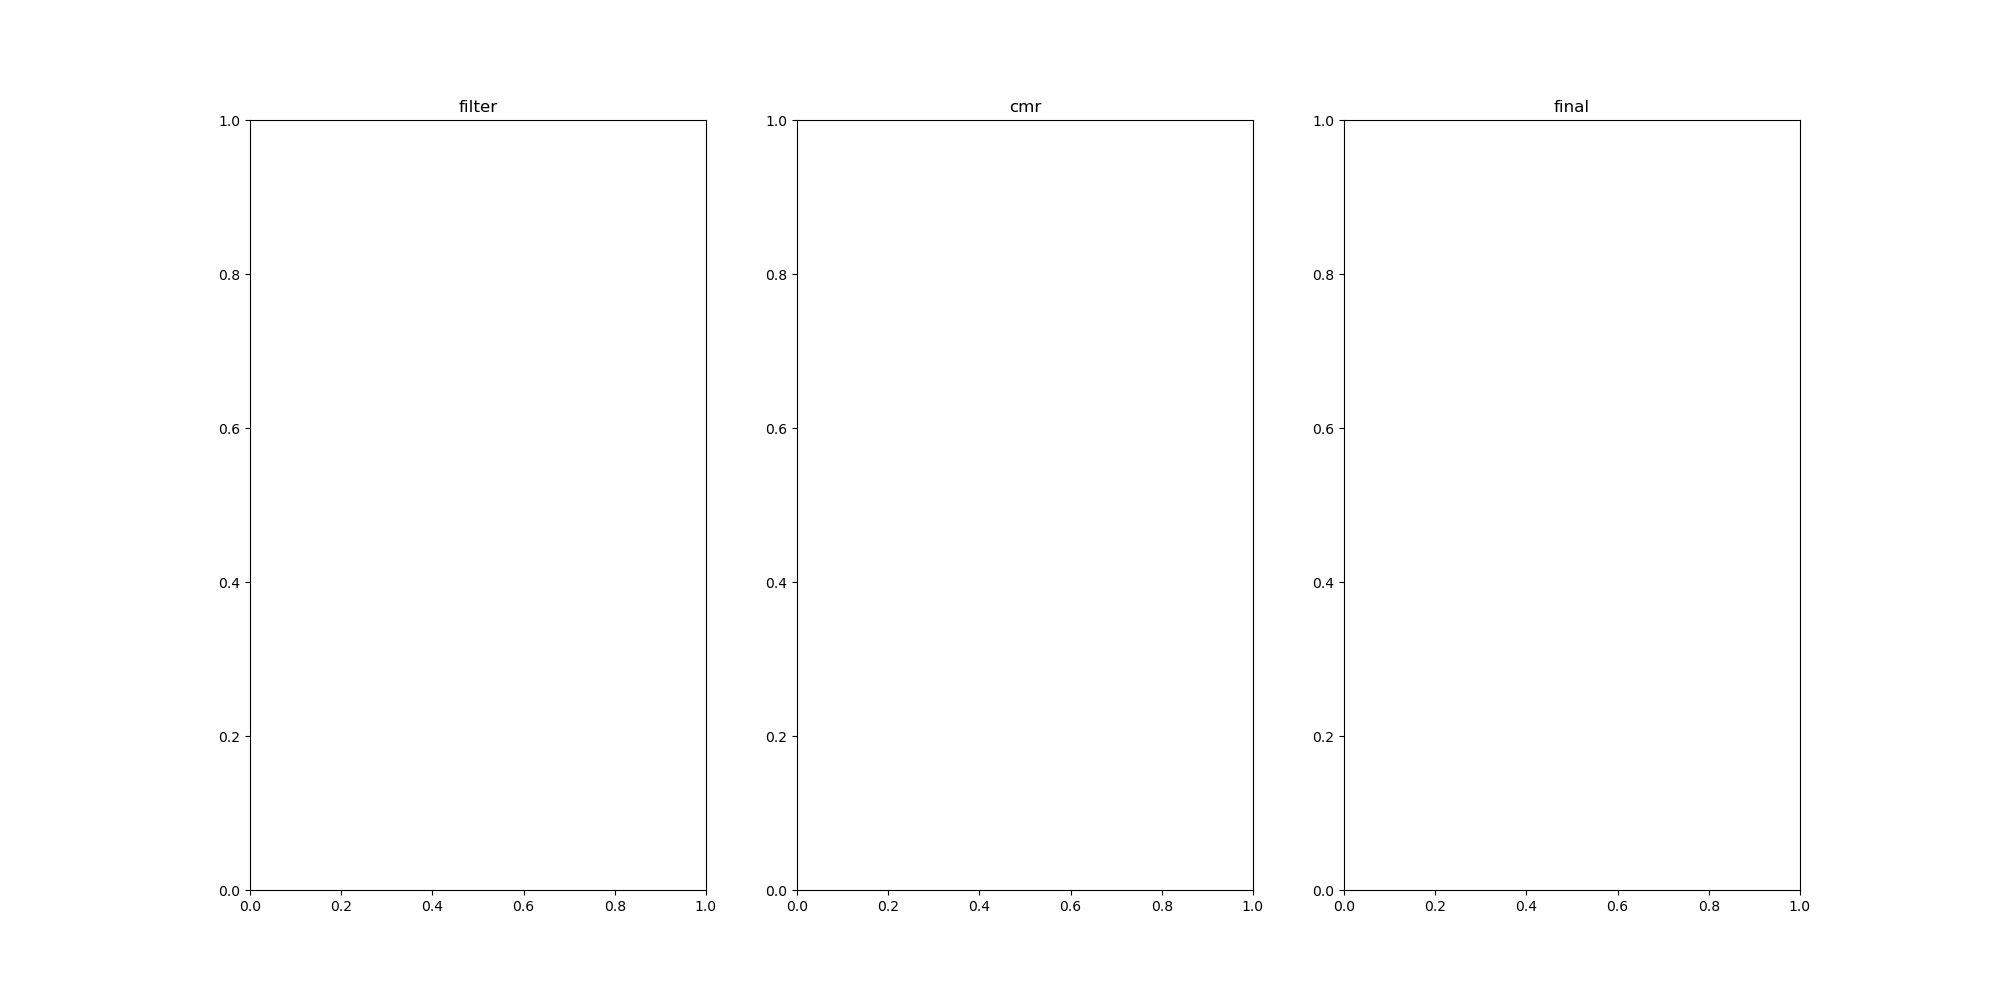

In [37]:
# here we use static plot using matplotlib backend
fig, axs = plt.subplots(ncols=3, figsize=(20, 10))

sw.plot_traces(rec1, backend='matplotlib',  clim=(-50, 50), ax=axs[0])
sw.plot_traces(rec4, backend='matplotlib',  clim=(-50, 50), ax=axs[1])
sw.plot_traces(rec_ap, backend='matplotlib',  clim=(-50, 50), ax=axs[2])
for i, label in enumerate(('filter', 'cmr', 'final')):
    axs[i].set_title(label)